In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [54]:
MODEL_NAME = "t2v+transformer"
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
MINUTES = 1
START_DATE = "2021-01-01"
END_DATE = "2024-12-31"
EVENT_NAME = "cusum_filter"
SEQUENCE_LENGTH = 60
TIME_COLS = [
    # 'timestamp',
    "hour",
    "dow",
    "dom",
    # "month",
    # "open",
    # "high",
    # "low",
    # "close",
]
FEATURES_COLS = [
    # Basic Data
    "close_log_return",
    "log_volume",
    "macd",
    "macd_signal",
    "macd_diff",
]
TARGET_COL = "bin_class"

In [55]:
from pathlib import Path

# Build base name
BASE_NAME = f"{SOURCE}-{SYMBOL}-tick-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
LABEL_NAME = f"{RESAMPLED_NAME}-{EVENT_NAME}"
# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
LABEL_DIR = BASE_DIR / "labels"
PROCESSED_DIR = BASE_DIR / "processed"
NORMALIZED_DIR = BASE_DIR / "normalized"
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"

# Final paths
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_processed.pkl"
NORMALIZED_FILE_PATH = NORMALIZED_DIR / f"{RESAMPLED_NAME}_normalized.pkl"
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [56]:
MODEL_PATH = '../lightning_logs/t2v+transformer-1-cusum_filter/version_23/checkpoints/best_checkpoint.ckpt'

In [57]:
SIDE_NAME = 'transformer_sides'

META_LABEL_DIR = BASE_DIR / "meta_labels"
META_LABEL_DIR.mkdir(parents=True, exist_ok=True)
META_LABEL_FILE_PATH = META_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}-{SIDE_NAME}.pkl"

In [58]:
%%time
df = pd.read_pickle(NORMALIZED_FILE_PATH)
labels_df = pd.read_pickle(DIRECTION_LABEL_FILE_PATH)

CPU times: user 2.64 ms, sys: 102 ms, total: 105 ms
Wall time: 204 ms


In [59]:
missing = labels_df.index.difference(df.index)
missing

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)

### Load Model

In [60]:
from models.classification.t2v_transformer_model import T2VTransformerModule

In [61]:
model = T2VTransformerModule.load_from_checkpoint(MODEL_PATH)

## Get Side from Trained Model

In [62]:
features = df[TIME_COLS + FEATURES_COLS]

In [64]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import torch

def get_side_from_model(model, data: pd.DataFrame, labels: pd.DataFrame, lookback: int = 24, device: str = 'cpu'):
    """
    Create a 'side' signal using linear regression trendline logic.
    
    Args:
        close (pd.Series): Close price series (indexed by datetime)
        t_events (pd.Index): Event timestamps (e.g., from MACD or CUSUM)
        lookback (int): Number of past bars to fit linear trend
    
    Returns:
        pd.Series: side signal indexed by t_events (1 = long, -1 = short)
    """
    
    model.eval()
    model.to(device)
    t_events = labels.index
    side = pd.Series(index=t_events, dtype='float32')

    for t in t_events:
        if t not in data.index:
            print(f"{t} is not in data index")
            continue
        try:
            end_loc = data.index.get_loc(t)
            start_loc = end_loc - lookback
            if start_loc < 0:
                continue  # not enough lookback
            seq = data.iloc[start_loc:end_loc].values.astype(np.float32)
            if seq.shape[0] != lookback:
                print('sequence length wrong')
                continue
            x_tensor = torch.tensor(seq).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = model(x_tensor)
                
                pred_class = int(torch.argmax(logits, dim=1).cpu().item())
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                # print(f"Probabilities: {probs} → Predicted class: {pred_class}")

            side[t] = pred_class

        except Exception as e:
            print(e)
            continue
        

    return side.dropna()


In [65]:
%%time
predicted_sides = get_side_from_model(model=model, data=features,labels=labels_df, lookback=60, device='cpu')
predicted_sides.value_counts(), predicted_sides.isna().sum()

CPU times: user 1min 10s, sys: 1min 5s, total: 2min 16s
Wall time: 1min 14s


(0.0    28096
 1.0     7145
 2.0     1742
 Name: count, dtype: int64,
 np.int64(0))

In [66]:
labels_df = labels_df.join(predicted_sides.rename("pred_class"))

In [67]:
labels_df.shape

(36985, 7)

In [68]:
labels_df = labels_df.dropna()

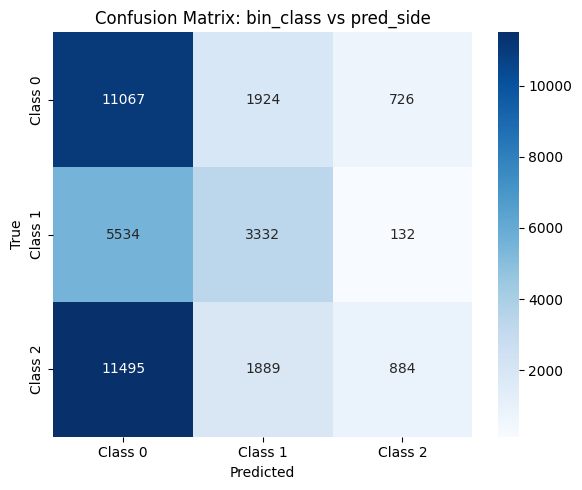

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假設你的資料是已合併過的 DataFrame（包含 bin_class 與 pred_side 欄位）
# 如果是從 CSV 或其他來源載入，請先用 pd.read_csv 或 .join 合併

# 將類別轉為整數型別
y_true = labels_df["bin_class"].astype(int)
y_pred = labels_df["pred_class"].astype(int)

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
labels = ["Class 0", "Class 1", "Class 2"]

# 繪圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: bin_class vs pred_side")
plt.tight_layout()
plt.show()
